In [1]:
import random,string,math,csv
import numpy as np
import matplotlib.pyplot as plt



In [2]:
all = list(csv.reader(open("atlas-higgs-challenge-2014-v2.csv","r"), delimiter=','))


In [3]:
print(all[1])

#xs = np.array([list(map(float, row[1:-2])) for row in all[1:]])
xs = np.array([list(map(float, row[1:-4])) for row in all[1:]])
print(xs[0])
(numPoints,numFeatures) = xs.shape

print(numFeatures)


['100000', '138.47', '51.655', '97.827', '27.98', '0.91', '124.711', '2.666', '3.064', '41.928', '197.76', '1.582', '1.396', '0.2', '32.638', '1.017', '0.381', '51.626', '2.273', '-2.414', '16.824', '-0.277', '258.733', '2', '67.435', '2.15', '0.444', '46.062', '1.24', '-2.475', '113.497', '0.00081448039868', 's', 't', '0.00265331133733']
[ 1.38470e+02  5.16550e+01  9.78270e+01  2.79800e+01  9.10000e-01
  1.24711e+02  2.66600e+00  3.06400e+00  4.19280e+01  1.97760e+02
  1.58200e+00  1.39600e+00  2.00000e-01  3.26380e+01  1.01700e+00
  3.81000e-01  5.16260e+01  2.27300e+00 -2.41400e+00  1.68240e+01
 -2.77000e-01  2.58733e+02  2.00000e+00  6.74350e+01  2.15000e+00
  4.44000e-01  4.60620e+01  1.24000e+00 -2.47500e+00  1.13497e+02]
30


In [4]:

#Perturbation légère
xs = np.add(xs, np.random.normal(0.0, 0.0001, xs.shape))


sSelector = np.array([row[-3] == 's' for row in all[1:]])
bSelector = np.array([row[-3] == 'b' for row in all[1:]])
#print(sSelector)


weights = np.array([float(row[-4]) for row in all[1:]])
sumWeights = np.sum(weights)
sumSWeights = np.sum(weights[sSelector])
sumBWeights = np.sum(weights[bSelector])

#print(weights)



In [5]:
randomPermutation = random.sample(range(numPoints), numPoints)
numPointsTrain = int(numPoints*0.8)
numPointsRest = numPoints - numPointsTrain
numPointsValidation= int(numPointsRest*0.5)
numPointstest= numPointsRest - numPointsValidation

xsTrain = xs[randomPermutation[:numPointsTrain]]
xsValidation = xs[randomPermutation[numPointsTrain:numPointsTrain + numPointsValidation]]

print(numPointsValidation)
print(numPointsRest)
print(numPointstest)
sSelectorTrain = sSelector[randomPermutation[:numPointsTrain]]
bSelectorTrain = bSelector[randomPermutation[:numPointsTrain]]
sSelectorValidation = sSelector[randomPermutation[numPointsTrain:numPointsValidation+numPointsTrain]]
bSelectorValidation = bSelector[randomPermutation[numPointsTrain:numPointsValidation+numPointsTrain]]

weightsTrain = weights[randomPermutation[:numPointsTrain]]
weightsValidation = weights[randomPermutation[numPointsTrain:numPointsValidation+numPointsTrain]]

sumWeightsTrain = np.sum(weightsTrain)
sumSWeightsTrain = np.sum(weightsTrain[sSelectorTrain])
sumBWeightsTrain = np.sum(weightsTrain[bSelectorTrain])

81824
163648
81824


In [6]:
xsTrainTranspose = xsTrain.transpose()


In [7]:


weightsBalancedTrain = np.array([0.5 * weightsTrain[i]/sumSWeightsTrain
                                 if sSelectorTrain[i]
                                 else 0.5 * weightsTrain[i]/sumBWeightsTrain\
                                 for i in range(numPointsTrain)])


print(weightsBalancedTrain[1][True])


[5.17211461e-06]


In [8]:
numBins = 10



logPs = np.empty([numFeatures, numBins])
binMaxs = np.empty([numFeatures, numBins])#Contient la valeur max d'une feature Fi des samples contenu dans chaque bin 
binIndexes = np.array(range(0, numPointsTrain+1, int(numPointsTrain/numBins)))

print(binIndexes)
print(xsTrainTranspose[7].argsort())

[     0  65459 130918 196377 261836 327295 392754 458213 523672 589131
 654590]
[ 88357 247428 318244 ... 313492 189378 480114]


In [9]:


for fI in range(numFeatures):
    # index permutation of sorted feature column
    indexes = xsTrainTranspose[fI].argsort() #Returns the indices that would sort this array.

    for bI in range(numBins):
        # upper bin limits
        binMaxs[fI, bI] = xsTrainTranspose[fI, indexes[binIndexes[bI+1]-1]]
        # training indices of points in a bin
        indexesInBin = indexes[binIndexes[bI]:binIndexes[bI+1]]
        # sum of signal weights in bin
        wS = np.sum(weightsBalancedTrain[indexesInBin]
                    [sSelectorTrain[indexesInBin]])
        # sum of background weights in bin
        wB = np.sum(weightsBalancedTrain[indexesInBin]
                    [bSelectorTrain[indexesInBin]])
        # log probability of being a signal in the bin
        logPs[fI, bI] = math.log(wS/(wS+wB))



In [10]:


def score(x):
    logP = 0
    for fI in range(numFeatures):
        bI = 0
        # linear search for the bin index of the fIth feature
        # of the signal
        while bI < len(binMaxs[fI]) - 1 and x[fI] > binMaxs[fI, bI]:
            bI += 1
        logP += logPs[fI, bI] - math.log(0.5)
    return logP



def AMS(s,b):
    assert s >= 0
    assert b >= 0
    bReg = 10.
    return math.sqrt(2 * ((s + b + bReg) * 
                          math.log(1 + s / (b + bReg)) - s))



In [11]:


validationScores = np.array([score(x) for x in xsValidation])



In [12]:
tIIs = validationScores.argsort() #Sorting the indices in increasing order of the scores.
wFactor = 1.* (numPoints-numPointstest) / numPointsValidation

s = np.sum(weightsValidation[sSelectorValidation])
b = np.sum(weightsValidation[bSelectorValidation])


In [13]:
amss = np.empty([len(tIIs)])

amsMax = 0
threshold = 0.0


for tI in range(len(tIIs)):
    # don't forget to renormalize the weights to the same sum 
    # as in the complete training set
    amss[tI] = AMS(max(0,s * wFactor),max(0,b * wFactor))
    if amss[tI] > amsMax:
        amsMax = amss[tI]
        threshold = validationScores[tIIs[tI]]
        #print tI,threshold
    if sSelectorValidation[tIIs[tI]]:
        s -= weightsValidation[tIIs[tI]]
    else:
        b -= weightsValidation[tIIs[tI]]



[1.03437319 1.03439136 1.03441053 ... 0.00393766 0.00262529 0.00131274]


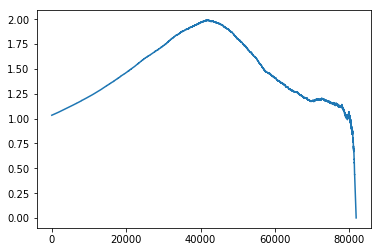

In [14]:
print(amss)

plt.plot(amss)



In [15]:
print(amsMax)
print(threshold)
print(validationScores[tIIs[39900]])

1.989990032081409
-0.04848652128776898
-0.3588198200627586


In [16]:
xsTest=xs[randomPermutation[numPointsTrain + numPointsValidation:numPointsTrain + numPointsValidation+numPointstest]]

testScores = np.array([score(x) for x in xsTest])

testInversePermutation = testScores.argsort()

sSelectorTest=sSelector[randomPermutation[numPointsValidation+numPointsTrain:numPointsValidation+numPointsTrain+numPointstest]]
bSelectorTest=bSelector[randomPermutation[numPointsValidation+numPointsTrain:numPointsValidation+numPointsTrain+numPointstest]]

In [17]:
testPermutation = list(testInversePermutation)
#print(testPermutation)
for tI,tII in zip(range(len(testInversePermutation)),
                  testInversePermutation):
    testPermutation[tII] = tI


In [18]:
weightsTest = weights[randomPermutation[numPointsValidation+numPointsTrain:numPointsValidation+numPointsTrain+numPointstest]]

prediction=np.empty([len(testScores)], dtype=str)

S=0 #TP non normalisé
B=0 #FP non normalisé

TP=0
FP=0

for tI in range(len(testScores)):
    if testScores[tI] >= threshold:
        prediction[tI]='s'
        if sSelectorTest[tI]:
            S += weightsTest[tI]
            TP+=1
        else:
            B += weightsTest[tI]
            FP+=1
    else:
        prediction[tI]='b'
        
#prediction = np.array(['s' if testScores[tI] >= threshold else 'b' for tI in range(len(testScores))])

print(list(prediction[1:30]))
print(list(sSelectorTest[1:30]))

ams=AMS(S,B)
print(ams)
print(TP/(TP+FP))

['b', 's', 'b', 's', 's', 'b', 'b', 's', 's', 's', 's', 'b', 's', 's', 'b', 'b', 'b', 's', 'b', 's', 'b', 'b', 's', 's', 'b', 's', 'b', 'b', 's']
[False, True, False, False, True, True, False, True, True, True, False, False, True, True, False, True, False, True, False, True, False, False, True, True, False, True, False, False, True]
0.6588486775016457
0.5656723175210021
